In [68]:
import numpy as np
import pandas as pd

import os
import json
import urllib 
import requests
import urllib.request
from tempfile import NamedTemporaryFile

from google.colab import files as FILE

import seaborn as sns
import matplotlib as mpl
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from mplsoccer import Pitch

plt.style.use('fivethirtyeight')

In [141]:
wwc = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/wwc_outcomes.csv')

squads = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/squads.csv')

codes = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-09/codes.csv')

In [ ]:
wwc

,year,team,score,round,yearly_game_id,team_num,win_status
0,1991,CHN,4,Group,1,1,Won
1,1991,NOR,0,Group,1,2,Lost
2,1991,DEN,3,Group,2,1,Won
3,1991,NZL,0,Group,2,2,Lost
4,1991,JPN,0,Group,3,1,Lost
...,...,...,...,...,...,...,...
563,2019,SWE,0,Semi Final,50,2,Lost
564,2019,ENG,1,Third Place Playoff,51,1,Lost
565,2019,SWE,2,Third Place Playoff,51,2,Won
566,2019,USA,2,Final,52,1,Won


In [ ]:
squads

,squad_no,country,pos,player,dob,age,caps,goals,club
0,1,US,GK,Alyssa Naeher,1988-04-20T00:00:00Z,31,43.0,0.0,Chicago Red Stars
1,2,US,FW,Mallory Pugh,1998-04-29T00:00:00Z,21,50.0,15.0,Washington Spirit
2,3,US,MF,Sam Mewis,1992-10-09T00:00:00Z,26,47.0,9.0,North Carolina Courage
3,4,US,DF,Becky Sauerbrunn,1985-06-06T00:00:00Z,34,155.0,0.0,Utah Royals
4,5,US,DF,Kelley O'Hara,1988-08-04T00:00:00Z,30,115.0,2.0,Utah Royals
...,...,...,...,...,...,...,...,...,...
547,19,France,DF,Griedge Mbock Bathy,1995-02-26T00:00:00Z,24,49.0,4.0,Lyon
548,20,France,FW,Delphine Cascarino,1997-02-05T00:00:00Z,22,11.0,1.0,Lyon
549,21,France,GK,Pauline Peyraud-Magnin,1992-03-17T00:00:00Z,27,1.0,0.0,Arsenal
550,22,France,DF,Julie Debever,1988-04-18T00:00:00Z,31,2.0,0.0,Guingamp


In [ ]:
codes

,country,team
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,ALG
3,American Samoa,ASA
4,Andorra,AND
...,...,...
207,Vietnam,VIE
208,Wales,WAL
209,Yemen,YEM
210,Zambia,ZAM


In [6]:
wwc = (wwc
       .merge(codes,on='team')
       .sort_values(['year','yearly_game_id'])
       .pivot(index=['year','yearly_game_id'], columns='team_num')
       )

wwc.columns = [ '_'.join([str(c) for c in c_list]) for c_list in wwc.columns.values ]

In [7]:
wwc = wwc.drop(columns='round_2').rename(columns={'round_1':'round'})

wwc['g_diff'] = (wwc.score_1 - wwc.score_2)
wwc['g_diff'] = np.where(wwc.g_diff < 0, wwc.g_diff*-1,wwc.g_diff)

wwc['g_diff1'] = (wwc.score_1 - wwc.score_2)
wwc['g_diff2'] = (wwc.score_2 - wwc.score_1)

In [8]:
so1 = (pd
      .DataFrame(
          (wwc['score_1'] == 0)
          .groupby(wwc['country_1'])
          .sum()
          )
      .merge(pd
              .DataFrame(
                  (wwc['score_2'] == 0)
                  .groupby(wwc['country_1'])
                  .sum()
                  )
              ,on='country_1')
      .reset_index()
      .rename(
          columns={'score_1':'shutouts_against_1','score_2':'shutouts_for_1','country_1':'country'}
          )
      )

so2 = (pd
      .DataFrame(
          (wwc['score_2'] == 0)
          .groupby(wwc['country_2'])
          .sum()
          )
      .merge(pd
              .DataFrame(
                  (wwc['score_1'] == 0)
                  .groupby(wwc['country_2'])
                  .sum()
                  )
              ,on='country_2')
      .reset_index()
      .rename(
          columns={'score_2':'shutouts_against_2','score_1':'shutouts_for_2','country_2':'country'}
          )
      )

so = pd.merge(so1,so2,on='country')

so['tot_shutouts_for'] = (so['shutouts_for_1'] + so['shutouts_for_2'])
so['tot_shutouts_against'] = (so['shutouts_against_1'] + so['shutouts_against_2'])

In [10]:
countries = [
         'United States','Germany','Brazil','Sweden','Norway',"China (People's Republic of China)",'Japan','France',
         'Canada','England','Italy','Netherlands','Denmark','Australia',
         'Colombia','Scotland','Costa Rica',"Côte d'Ivoire",'Jamaica','Switzerland','Ecuador',
         'South Africa','Equatorial Guinea','Chile','Spain','Cameroon','Taiwan (Republic of China)','Thailand',
         'Mexico','Ghana','Korea, Republic of','Argentina',"Korea, Democratic People's Republic of",'New Zealand','Nigeria'
         ]

url = requests.get('https://raw.githubusercontent.com/hampusborgos/country-flags/main/countries.json')
p = url.json()

fl = {k:v for k,v in p.items() if v in countries}
fl_r = {v:k for k,v in p.items() if v in countries}

In [11]:
fl

{'AR': 'Argentina',
 'AU': 'Australia',
 'BR': 'Brazil',
 'CA': 'Canada',
 'CH': 'Switzerland',
 'CI': "Côte d'Ivoire",
 'CL': 'Chile',
 'CM': 'Cameroon',
 'CN': "China (People's Republic of China)",
 'CO': 'Colombia',
 'CR': 'Costa Rica',
 'DE': 'Germany',
 'DK': 'Denmark',
 'EC': 'Ecuador',
 'ES': 'Spain',
 'FR': 'France',
 'GB-ENG': 'England',
 'GB-SCT': 'Scotland',
 'GH': 'Ghana',
 'GQ': 'Equatorial Guinea',
 'IT': 'Italy',
 'JM': 'Jamaica',
 'JP': 'Japan',
 'KP': "Korea, Democratic People's Republic of",
 'KR': 'Korea, Republic of',
 'MX': 'Mexico',
 'NG': 'Nigeria',
 'NL': 'Netherlands',
 'NO': 'Norway',
 'NZ': 'New Zealand',
 'SE': 'Sweden',
 'TH': 'Thailand',
 'TW': 'Taiwan (Republic of China)',
 'US': 'United States',
 'ZA': 'South Africa'}

In [12]:
so['country_code'] = so['country'].copy()

so.at[6,'country_code'] = "China (People's Republic of China)"
so.at[7,'country_code'] = "Taiwan (Republic of China)"
so.at[18,'country_code'] = "Côte d'Ivoire"
so.at[25,'country_code'] = "Korea, Democratic People's Republic of"
so.at[29,'country_code'] = "Korea, Republic of"

In [13]:
so['flag_code'] = so.country_code.map(fl_r)

In [15]:
for i in list(so['flag_code']):
  if type(i) != str:
    pass
  else:
    img_data = requests.get(
        f'https://raw.githubusercontent.com/hampusborgos/country-flags/main/png250px/{i.lower()}.png'
        ).content
    with open(f'{i}.jpg', 'wb') as handler:
        handler.write(img_data)

In [16]:
flags = pd.DataFrame([x for x in os.listdir() if x.endswith('.jpg')],columns=['path'])

In [17]:
flags['country_code'] = flags.path.map(lambda x:x.split('.', 1)[0])

In [19]:
flags.country_code = flags.country_code.map(fl)

In [20]:
so = so.merge(flags,on='country_code')

In [21]:
so

,country,shutouts_against_1,shutouts_for_1,shutouts_against_2,shutouts_for_2,tot_shutouts_for,tot_shutouts_against,country_code,flag_code,path
0,Argentina,2,1,4,0,1,6,Argentina,AR,AR.jpg
1,Australia,1,1,2,1,2,3,Australia,AU,AU.jpg
2,Brazil,4,10,2,7,17,6,Brazil,BR,BR.jpg
3,Cameroon,0,1,3,0,1,3,Cameroon,CM,CM.jpg
4,Canada,3,6,2,1,7,5,Canada,CA,CA.jpg
5,Chile,1,0,1,1,1,2,Chile,CL,CL.jpg
6,China PR,5,9,6,3,12,11,China (People's Republic of China),CN,CN.jpg
7,Chinese Taipei,2,1,1,0,1,3,Taiwan (Republic of China),TW,TW.jpg
8,Colombia,1,0,3,2,2,4,Colombia,CO,CO.jpg
9,Costa Rica,1,0,0,0,0,1,Costa Rica,CR,CR.jpg


In [37]:
github_url = 'https://github.com/google/fonts/blob/main/ofl/kanit/Kanit-Regular.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

response = urllib.request.urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

prop = fm.FontProperties(fname=f.name)

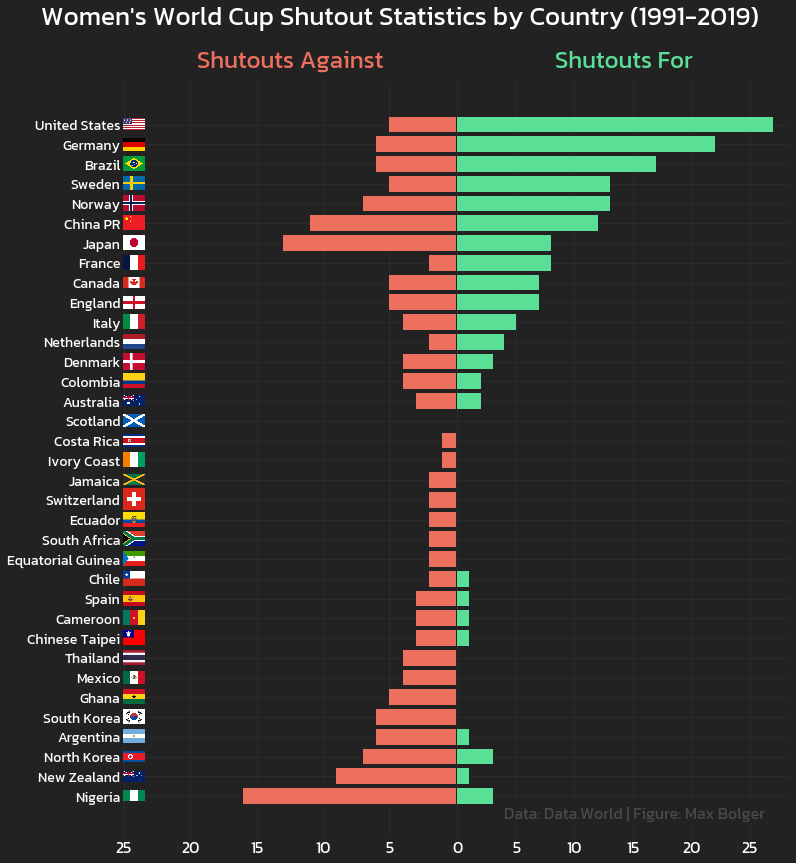

In [62]:
fig, ax = plt.subplots(figsize=(12,14),ncols=2,sharey=True,facecolor='#222222',edgecolor='#222222')


for i in ax.flatten():
  i.set_facecolor("#222222")
  i.tick_params(axis='x', colors='white')
  i.tick_params(axis='y', colors='white')
  i.grid(zorder=0,alpha=.5,color='#353535')
  for j in ['left','right','top','bottom']:
    i.spines[j].set_visible(False)
  for label in i.get_xticklabels():
    label.set_fontproperties(prop)

  for label in i.get_yticklabels():
    label.set_fontproperties(prop)

  i.tick_params(axis='x', labelsize=16)

order = [
         'United States','Germany','Brazil','Sweden','Norway','China PR','Japan','France',
         'Canada','England','Italy','Netherlands','Denmark','Colombia','Australia',
         'Scotland','Costa Rica','Ivory Coast','Jamaica','Switzerland','Ecuador',
         'South Africa','Equatorial Guinea','Chile','Spain','Cameroon','Chinese Taipei','Thailand',
         'Mexico','Ghana','South Korea','Argentina','North Korea','New Zealand','Nigeria'
         ]

viz = so.sort_values(by='tot_shutouts_for')
viz.at[18,'country'] = 'Ivory Coast'
viz = viz.set_index('country').reindex(reversed(order)).reset_index()

fig.tight_layout()

ax[0].barh('country','tot_shutouts_against',align='center',color='#ed6f5e',data=viz)
ax[1].barh('country','tot_shutouts_for',align='center',color='#59e096',data=viz)

ax[0].invert_xaxis()

ax[0].set_xticks([5,10,15,20,25])

ax[0].set_title('Shutouts Against',fontproperties=prop,fontsize=24,color='#ed6f5e',pad=15)
ax[1].set_title('Shutouts For',fontproperties=prop,fontsize=24,color='#59e096',pad=15)

ax[0].tick_params(axis='y', labelsize=14)

(plt
 .suptitle("Women's World Cup Shutout Statistics by Country (1991-2019)",
           fontproperties=prop,fontsize=26,color='white',y=0.925)
 )

plt.subplots_adjust(wspace=0.005,top=0.85,bottom=0.1,left=0.18,right=0.95)

def getImage(path): 
    return OffsetImage(plt.imread(path),zoom=0.085)

for x0, y0, path in zip([24.25]*35,np.arange(0,35),viz['path']):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax[0].add_artist(ab)

props = dict(boxstyle='round', facecolor='#222222', edgecolor='#222222',alpha=0.8)

(plt
 .figtext(0.62,0.12,'Data: Data.World | Figure: Max Bolger',
          fontproperties=prop,color='#494949',fontsize=16,bbox=props)
 )

# lightcoral lightgreen

# ed655a
# #72bf47

#59e096
#ed6f5e

plt.savefig('wk5_shutouts.png',dpi=300,bbox_inches='tight',facecolor=fig.get_facecolor())

In [ ]:
g_diff = (wwc
          .groupby('country_2')
          .agg({'g_diff2':'sum','team_2':'count'})
          .reset_index()
          .rename(columns={'country_2':'country'})
          .merge(wwc
                 .groupby('country_1')
                 .agg({'g_diff1':'sum','team_1':'count'})
                 .reset_index()
                 .rename(columns={'country_1':'country'})
                 ,on='country')
          )

g_diff['tot_games'] = g_diff.team_2 + g_diff.team_1
g_diff['tot_diff'] = g_diff.g_diff2 + g_diff.g_diff1
g_diff['gm_diff'] = g_diff.tot_diff / g_diff.tot_games

g_diff.sort_values(by='gm_diff',ascending=False)

,country,g_diff2,team_2,g_diff1,team_1,tot_games,tot_diff,gm_diff
34,United States,36,21,64,29,50,100,2.000000
15,Germany,20,14,61,30,44,81,1.840909
32,Switzerland,-2,2,8,2,4,6,1.500000
26,Norway,2,15,39,25,40,41,1.025000
2,Brazil,13,14,13,20,34,26,0.764706
17,Italy,10,7,-1,5,12,9,0.750000
6,China PR,-3,11,25,22,33,22,0.666667
14,France,8,8,4,11,19,12,0.631579
31,Sweden,11,22,12,18,40,23,0.575000
22,Netherlands,1,6,5,5,11,6,0.545455


In [ ]:
wcc['round'].value_counts()

Group                  204
Quarter Final           32
Semi Final              16
Round of 16             16
Third Place Playoff      8
Final                    8
Name: round, dtype: int64

In [ ]:
wcc.groupby(['year']).shutout.mean()

year
1991    0.653846
1995    0.538462
1999    0.468750
2003    0.531250
2007    0.593750
2011    0.500000
2015    0.519231
2019    0.596154
Name: shutout, dtype: float64

In [ ]:
wcc.loc[wcc['round'] == 'Group'].groupby(['year']).g_diff.mean()

year
1991    2.833333
1995    2.444444
1999    2.750000
2003    2.541667
2007    2.208333
2011    1.500000
2015    1.750000
2019    2.027778
Name: g_diff, dtype: float64

In [63]:
COLORS1 = {
    
    'Orlando Pride':'#633394',
    'São Paulo':'#fe0000',
    'Portland Thorns':'#971d1f',
    'Chelsea':'#034694',
    'West Ham United':'#7c2c3b',
    'Lyon':'#003a80',
    'Kolbotn':'#275ba1',
    'Utah Royals':'#000034',
    'Barcelona':'#edbb00'

}

COLORS2 = {
    
    'Orlando Pride':'#00a7e1',
    'São Paulo':'#000000',
    'Portland Thorns':'#ffffff',
    'Chelsea':'#ed1c24',
    'West Ham United':'#2dafe5',
    'Lyon':'#d49f45',
    'Kolbotn':'#ffffff',
    'Utah Royals':'#fdb71a',
    'Barcelona':'#004d98'
    
}

LOGOS = {
    
    'Orlando Pride':'Orlando Pride.png',
    'São Paulo':'Sao Paulo.png',
    'Portland Thorns':'Portland Thorns.png',
    'Chelsea':'Chelsea.png',
    'West Ham United':'West Ham United.png',
    'Lyon':'Lyon.png',
    'Kolbotn':'Kolbotn.png',
    'Utah Royals':'Utah Royals.png',
    'Barcelona':'Barcelona.png'
    
}

In [64]:
github_url = 'https://github.com/google/fonts/blob/main/ofl/comfortaa/Comfortaa%5Bwght%5D.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

response = urllib.request.urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

prop = fm.FontProperties(fname=f.name)

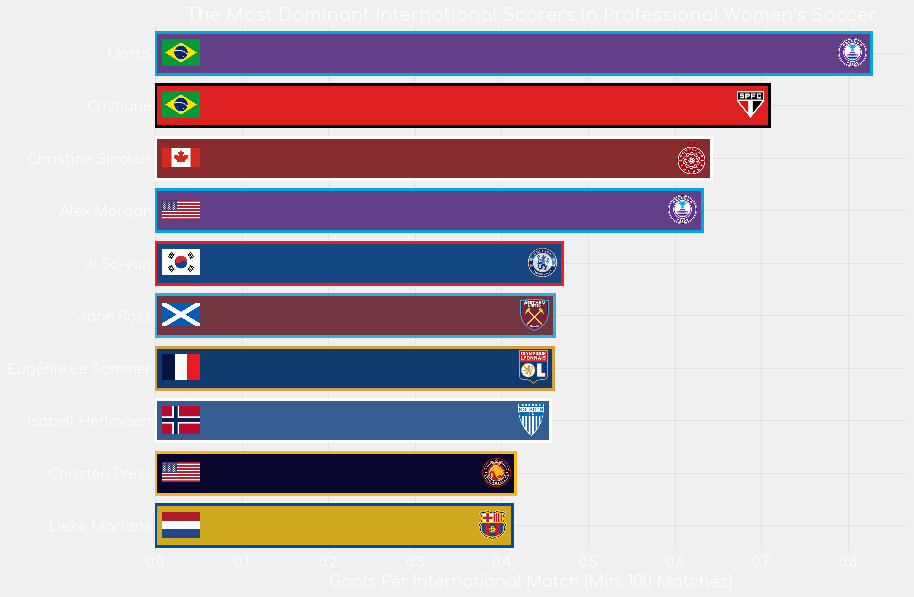

In [143]:
def getImage(path): 
    return OffsetImage(plt.imread(path),zoom=.2)

def getImage2(path): 
    return OffsetImage(plt.imread(path),zoom=.15)

squads['gpg'] = squads['goals'] / squads['caps']

viz = squads.loc[squads.caps >=100].sort_values(by='gpg',ascending=False).head(10)

viz.at[22,'country'] = "United States"
viz.at[12,'country'] = "United States"
viz.at[469,'country'] = "Korea, Republic of"

viz = viz.rename(columns={'country':'country_code'})
viz = viz.merge(flags,on='country_code').sort_values(by='gpg',ascending=False).head(10)

viz['logo'] = viz.club.map(LOGOS)

fig, ax = plt.subplots(figsize=(12,9))

for x0, y0, path in zip(viz['gpg']-.022,np.arange(0,10),viz['logo']):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

for x0, y0, path in zip([0.03]*10,np.arange(0,10),viz['path']):
    ab = AnnotationBbox(getImage2(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

(sns
 .barplot(x=viz.gpg,y=viz.player,palette=viz.club.map(COLORS1),
          ec=viz.club.map(COLORS2),linewidth=3)
 )

plt.ylabel('')
(plt
 .xlabel('Goals Per International Match (Min. 100 Matches)',
         color='white',fontproperties=prop,fontsize=16)
 )

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

for label in ax.get_xticklabels():
    label.set_fontproperties(prop)

for label in ax.get_yticklabels():
    label.set_fontproperties(prop)

for i in ['left','right','top','bottom']:
  ax.spines[i].set_visible(False)

ax.grid(alpha=.07,color='#1f1f1f')

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

(plt
 .title("The Most Dominant International Scorers in Professional Women's Soccer",
        fontproperties=prop,fontsize=18,color='white')
 )

plt.savefig('bars.png',dpi=300,bbox_inches='tight',transparent=True)

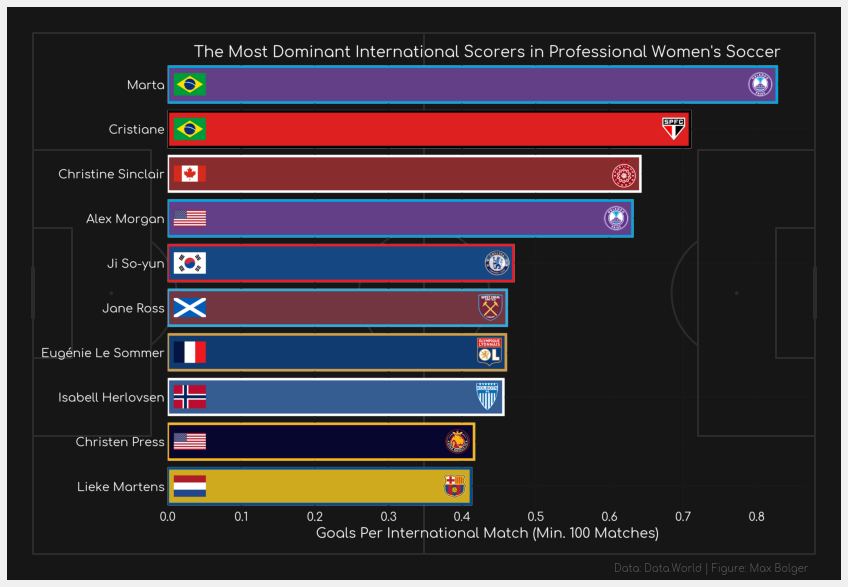

In [145]:
pitch = Pitch(pitch_color='#161616', line_color='#2b2b2b')

fig, ax = pitch.draw(figsize=(12,9))

ax2 = fig.add_axes([0.05,.05,.9,.9]) # badge
ax2.axis("off")

ax2.imshow(img.imread('bars.png'))

plt.figtext(0.72,0.07,'Data: Data.World | Figure: Max Bolger',fontproperties=prop,fontsize=10,color='#515151')

plt.savefig('wk5_scorers.png',dpi=300,bbox_inches='tight',facecolor='#161616')